<h3>Final Project Submission |
Team Members: Shabeena Khoja & Shalini Gopalakrishnan </h3>

In [1]:
#Import required packages
import pandas as pd
import numpy as np
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
%pylab inline
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus
import xlrd

Populating the interactive namespace from numpy and matplotlib


In [2]:
ccars = pd.read_excel('CCARs.xlsx')
services = pd.read_excel('Services.xlsx')

<h2>Question 1:Which Services are converted into Claims?</h2>

#### Step 1: Data Preparation

In [26]:
#Convert the SOURCE column into 0 and 1
services['CLAIM']= [1 if i=='Claim' else 0 for i in services.SOURCE]

#### Step 2: Summary of Finding

<h3>The lower the Paid Amount and the number of Service Units, the more likely a Service will be converted to Claim – <font color='blue'>63% of the total number of services with service units <= 1.5 and paid amount <= 31 were converted to Claims</font></h3>

#### Step 2.1: Validating finding - Graph 1

In [27]:
finding1_1 = services.copy()

In [28]:
finding1_1['SERVICE_UNITS_BIN'] = pd.cut(finding2_1.SERVICE_UNITS,include_lowest=True, bins = [0,1.5,4,5,10,15,20,25,30,35,41])

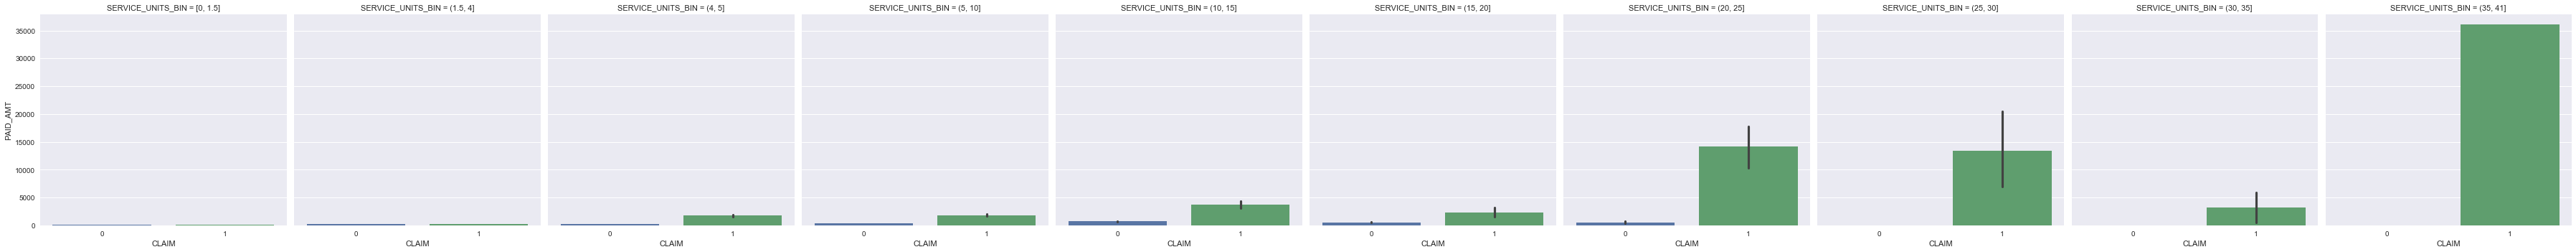

In [29]:
sns.factorplot(x='CLAIM',y='PAID_AMT',data=finding1_1,kind='bar',size=5,
              col='SERVICE_UNITS_BIN')

The above graph shows that for lesser Service Units, the PAID_AMT for Claims is less. However, because we're trying to plot all the SERVICE_UNITS it is difficult to imagine how less the PAID_AMT is in case of lower SERVICE_UNITS. To show this in more detail, let's see how the plot looks like for SERVICE_UNITS under 5

#### Step 2.2: Validating finding - Graph 2

In [30]:
finding1_2 = services[services.SERVICE_UNITS < 5]

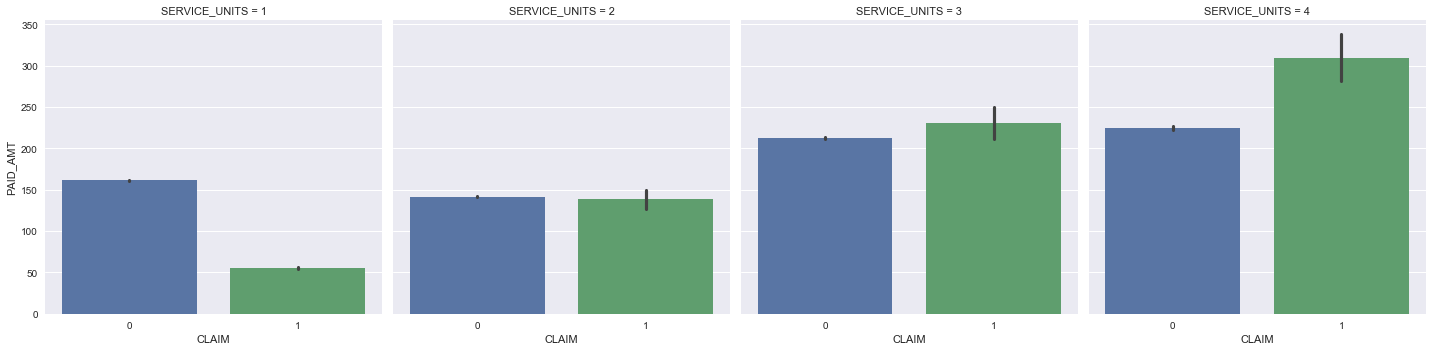

In [31]:
sns.factorplot(x='CLAIM',y='PAID_AMT',data=finding1_2,kind='bar',size=5,
              col='SERVICE_UNITS')

As we see in the above graph, the finding (that PAID_AMT for Claims is less than the PAID_AMT for Enocunters) is prominent for lower SERVICE_UNITS

#### Step 3: Machine Learning

We detected this finding by training the following decision tree with CLAIM as target attribute.

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

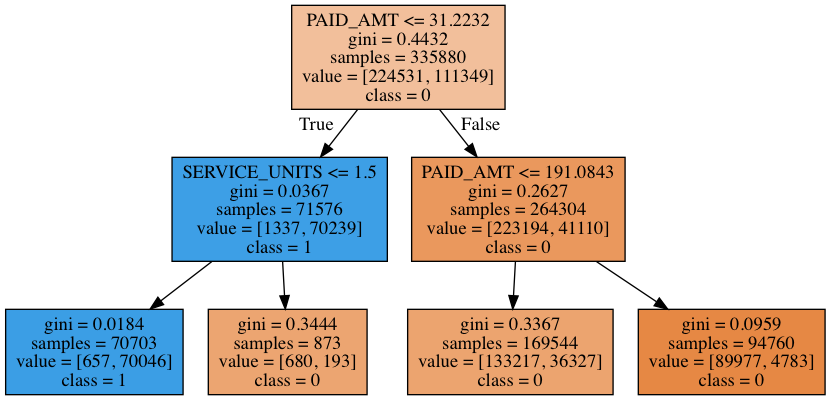

In [32]:
claimtree = services[['SERVICE_UNITS','CLAIM','PAID_AMT']].copy()

X = claimtree.drop('CLAIM',axis=1)
Y = claimtree['CLAIM']
dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X,Y)
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

The first split was made on the PAID_AMT, which suggests that amount paid by patients has a relationship with CLAIMS made. The second split made for SERVICE_UNITS helped to identify the population where CLAIMS = 1. Therefore, we concluded that all services with lower Service Units (<=1.5) were converted to Claims as the amount patients had to pay for their services were lower (<= 31.22).

<h2>Question 2: Which diagnoses are leading to more Claims? </h2>

#### Step 1: Data Preparation

In [54]:
#keep only relevant attributes for finding 2
finding2 = services[['SERVICE_UNITS','DIAGNOSIS','CLAIM']]
#dummy DIAGNOSIS attribute for findings related to specific diagnosis types
finding2 = pd.get_dummies(data=finding2,columns=['DIAGNOSIS'])

#### Step 2: Summary of Finding

<h3>
<ul>
<li>Services undertaken for Opioid Dependence Uncomplicated and with Service Units under 1.5 are most likely converted to Claims - <font color='blue'> 52% of the total number of services which are claims</font></li><br>
<li>Services undertaken for Opioid Dependence Continuous are most likely converted to Claims – <font color='blue'> 7% of the total number of services which are claims</font></li>
<ul>
</h3>

#### Step 2.1: Validating finding - Table 1

In [38]:
finding2_1['SERVICE_UNITS_BIN'] = pd.cut(finding2_1.SERVICE_UNITS,include_lowest=True, bins = [0,1.5,4,5,10,15,20,25,30,35,41])
finding2_grp = finding2_1.groupby(['DIAGNOSIS','SERVICE_UNITS_BIN'],as_index=False).agg({'CLAIM' : lambda x:len(x[x.values==1])})
finding2_grp.nlargest(10,columns = 'CLAIM')

,DIAGNOSIS,SERVICE_UNITS_BIN,CLAIM
767,"Opioid Dependence, Uncomplicated","[0, 1.5]",58687
773,"Opioid Type Dependence, Continuous","[0, 1.5]",7437
590,"Illness, Unspecified","[0, 1.5]",2304
52,"Adjustment Disorder, Unspecified","[0, 1.5]",2140
768,"Opioid Dependence, Uncomplicated","(1.5, 4]",2039
513,"Depressive Disorder, Not Elsewhere Classified","[0, 1.5]",1945
959,"Post-Traumatic Stress Disorder, Unspecified","[0, 1.5]",1933
177,"Anxiety Disorder, Unspecified","[0, 1.5]",1877
118,"Alcohol Dependence, Uncomplicated","(1.5, 4]",1863
117,"Alcohol Dependence, Uncomplicated","[0, 1.5]",1708


As seen in the above table, patients with diagnosis type 'Opioid Dependence, Uncomplicated' and 'Opioid Type Dependence, Continuous' and lower service units(0-1.5) are the top two categories for Claims in comparison to all other diagnosis types.

#### Step 2.2: Validating finding - Graph 1

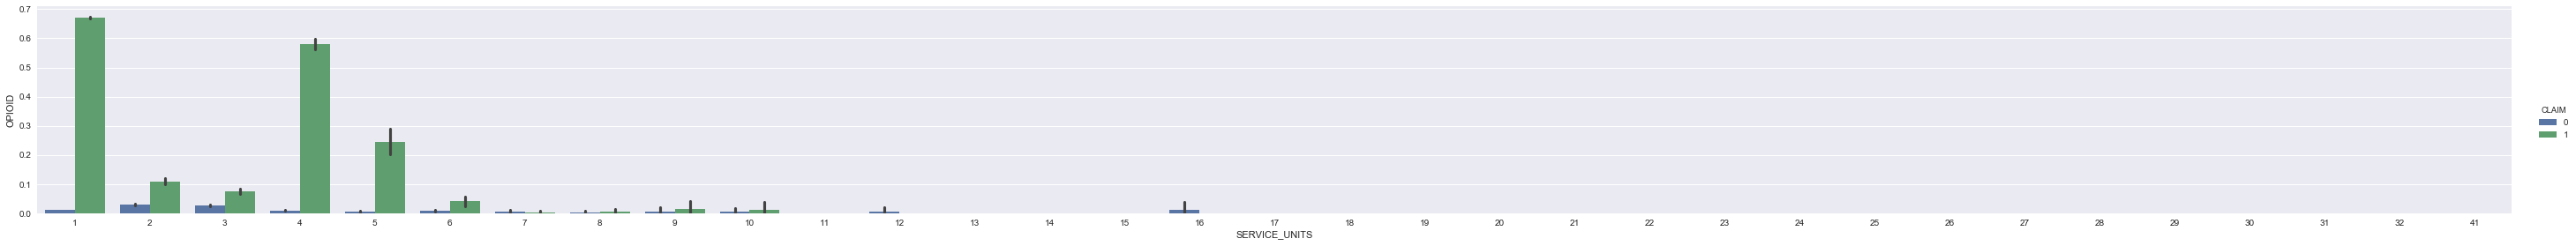

In [36]:
finding2_1 = services.copy()
finding2_1['CLAIM']= [1 if i=='Claim' else 0 for i in finding2_1.SOURCE]
finding2_1['OPIOID'] = [1 if (i=='Opioid Dependence, Uncomplicated') | (i == 'Opioid Type Dependence, Continuous') else 0 for i in finding2_1.DIAGNOSIS]
sns.factorplot(y='OPIOID',x='SERVICE_UNITS',hue='CLAIM',data=finding2_1,aspect=10,kind='bar')

The above graph shows that for Services with lesser SERVICE_UNITS (<=6) and with Diagnosis of Type Opioid (Opioid Dependence, Uncomplicated and Opioid Type Dependence, Continuous) are leading to more Claims. 

#### Step 3: Machine Learning

For this finding, we included  DIAGNOSIS and SERVICE_UNITS as independent variables and trained the following decision tree with CLAIM as the target attribute

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

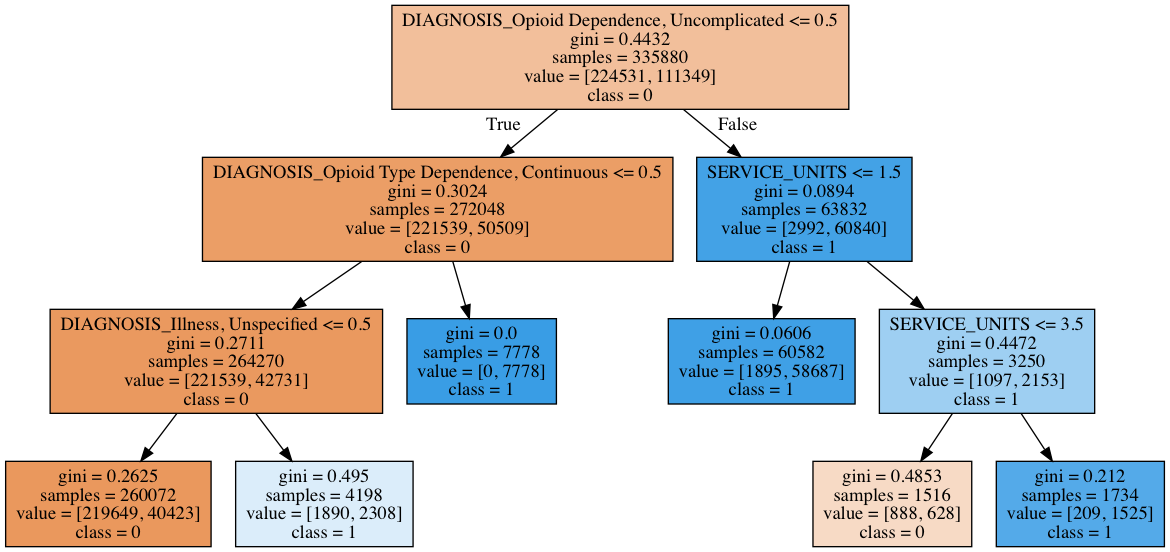

In [57]:
X = finding2.drop('CLAIM',axis=1)
Y = finding2['CLAIM']
dt = tree.DecisionTreeClassifier(max_depth=3)
dt.fit(X,Y)
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

The first split was made on DIAGNOSIS with Opioid Dependence Uncomplicated. There are two important observations on either sides of the tree. The right hand side of the tree indicates that services rendeered for Opioid Dependence Uncomplicated and which have SERVICE_UNITS less than or equal to 1.5 are convereted to Claims. 
The left hand side of the tree suggests that services rendered for Opioid Type Dependence Continuous are also likely to be converted to Claims. 

<h2>Question 3: Which patients are at higher risk of re-hospitalization? </h2>

#### Step 1: Data Preparation

In [3]:
finding3 = services[services.SERVICE_TYPE == 'INPATIENT'].copy()
finding3['PREV_DATE'] = finding3['SERVICE_DATE']

<b>Shift date by 1 day</b>

In [4]:
def shiftdate(x):
    x.PREV_DATE = x.PREV_DATE.shift(1)
    return x

In [5]:
finding3 = finding3.groupby(['CLIENT_ID'],as_index=False).apply(lambda x: shiftdate(x))

<b>Calculate number of rehospitalization days</b>

In [6]:
finding3['REHOSP_DAYS'] = finding3['SERVICE_DATE'] - finding3['PREV_DATE']
finding3['REHOSP_DAYS'] = finding3['REHOSP_DAYS'].dt.days

<b>Remove NaNs</b>

In [7]:
finding3['REHOSP_DAYS'] = [0 if math.isnan(i) else i for i in finding3.REHOSP_DAYS]

<b>Merge datasets</b>

In [8]:
rhcars = finding3.merge(ccars)

<b>Retain one record per inpatient</b>

In [9]:
rhcars_dd = rhcars.drop_duplicates(subset=['SERVICE_DATE','CLIENT_ID'],keep='first')

<b>Considering only records when rehospitalization is > 0 days and <= 90 days</b>

In [10]:
rhcars_dd = rhcars_dd[(rhcars_dd.REHOSP_DAYS > 0) & (rhcars_dd.REHOSP_DAYS <= 90)]

<b>Considering RISK to be high when Rehospitalization days <= 10</b>

In [11]:
rhcars_dd['RISK'] = [1 if i<=10 else 0 for i in rhcars_dd.REHOSP_DAYS]

<b>Group related diagnoses together</b>

In [12]:
def changeDiag(dg):
    if "Adjustment Disorder" in dg:
        return "Adjustment Disorder"
    elif "Bipolar" in dg:
        return "Bipolar Disorder"
    elif "Schizo" in dg:
        return "Schizophrenia"
    elif "Depressive" in dg:
        return "Depressive Disorder"
    elif "Stress Disorder" in dg:
        return "Stress Disorder"
    elif "Stimulant Abuse" in dg:
        return "Stimulant Abuse"
    else:
        return dg

In [13]:
rhcars_dd['NEW_DIAGNOSIS'] = rhcars_dd['DIAGNOSIS'].apply(lambda x: changeDiag(x))

<b>So, this reduces number of diagnoses from 44 to 12</b>

In [14]:
len(rhcars_dd['NEW_DIAGNOSIS'].unique())
len(rhcars_dd['DIAGNOSIS'].unique())

12

44

<b>Data prep steps for validation - including the entire data set which has both inpatients and non-inpatients</b>

In [15]:
plot = services.merge(ccars)
plot = plot.drop_duplicates(subset=['SERVICE_DATE','CLIENT_ID'],keep='first')
plot['PREV_DATE'] = plot['SERVICE_DATE']
plot = plot.groupby(['CLIENT_ID','SERVICE_TYPE'],as_index=False).apply(lambda x: shiftdate(x))
plot['REHOSP_DAYS'] = plot['SERVICE_DATE'] - plot['PREV_DATE']
plot['REHOSP_DAYS'] = plot['REHOSP_DAYS'].dt.days
plot['REHOSP_DAYS'] = [0 if math.isnan(i) else i for i in plot.REHOSP_DAYS]
plot['REHOSP_DAYS'] = [i if i=='INPATIENT' else 0 for i in plot.SERVICE_TYPE]
plot['RH'] = [1 if i>0 else 0 for i in plot.REHOSP_DAYS]
plot['INPATIENT'] = [1 if i=='INPATIENT' else 0 for i in plot.SERVICE_TYPE]
plot['NEW_DIAGNOSIS'] = plot['DIAGNOSIS'].apply(lambda x: changeDiag(x))

<b> Step 2:Summary of finding:</b>

<h3>
<ul>
<li>Patients diagnosed with Bipolar Disorder and who are Homeless are at a higher risk of being re-hospitalized – <font color='blue'>22% of the total numbers of in-patients who are re-hospitalized within 1 to 90 days</font></li><br>
<li>Patients under Assisted Living are at a higher risk of being re-hospitalized - <font color='blue'>9% of the total numbers of in-patients who are re-hospitalized within 1 to 90 days</font></li>
</ul>
</h3>

<b>Step 2.1: Validating finding - Table 1</b>

In [16]:
plot['NEW_DIAGNOSIS_2'] = plot['NEW_DIAGNOSIS']
new = plot.groupby(['SERVICE_TYPE','HOUSING'],as_index=False).agg({'NEW_DIAGNOSIS_2' : lambda x:len(x[x.values=='Bipolar Disorder']), 'NEW_DIAGNOSIS' : lambda x : len(x[x.values=='Bipolar Disorder'])/(len(x)+0.0), 'CLIENT_ID' : {'Number of services': 'size'}                                             })
new.columns=['SERVICE_TYPE','HOUSING','Proportion','Number of patients with bipolar','Number of services']
new[new.HOUSING == 12].nlargest(20,columns='Proportion')

,SERVICE_TYPE,HOUSING,Proportion,Number of patients with bipolar,Number of services
39,INPATIENT,12,0.416667,45,108
9,ATU,12,0.337435,905,2682
25,CASE MGT,12,0.247544,1411,5700
67,RESPITE,12,0.200000,10,50
55,OUTPATIENT,12,0.193571,1933,9986
92,VOCATIONAL,12,0.057143,14,245
80,SUD,12,0.000000,0,7473


As we see in the above graph, the proportion of patients who suffer from Bipolar Disorder and who are homeless are more likely to be hospitalized.

<b>Step 2.2: Validating finding - Graph</b>

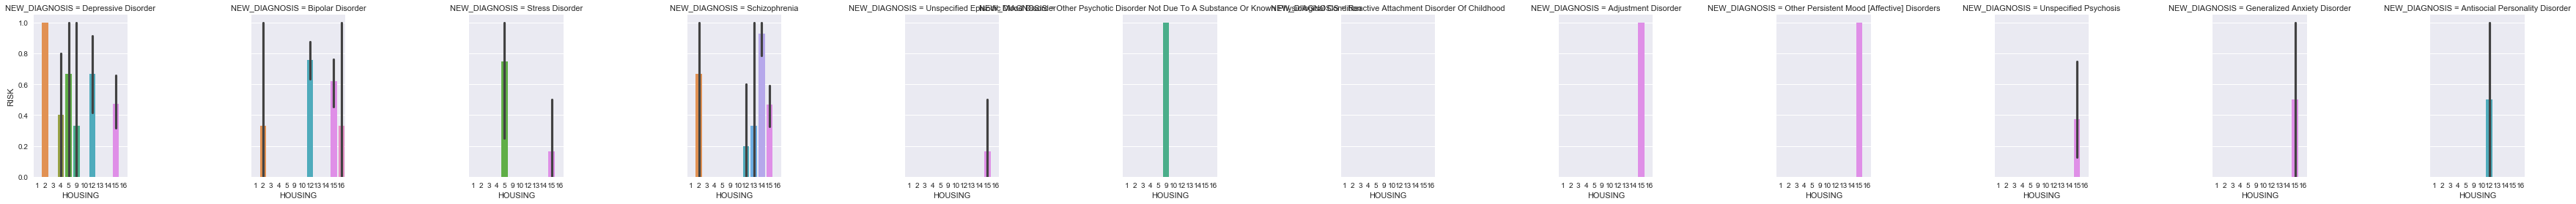

In [17]:
sns.factorplot(x='HOUSING',y='RISK',data=rhcars_dd,aspect=1,kind='bar',col='NEW_DIAGNOSIS')

From the above graph, we see that among the inpatients, those suffering from Bipolar Disorder(NEW_DIAGNOSIS = Bipolar Disorder) and who are homeless(HOUSING = 12) have a higher risk of rehospitilization.
<br>Please refer second panel where NEW_DIAGNOSIS = Bipolar Disorder

<b>Step 3: Machine learning</b>

For this finding, we included  DIAGNOSIS and HOUSING as independent variables and trained the following decision tree with RISK as the target attribute

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

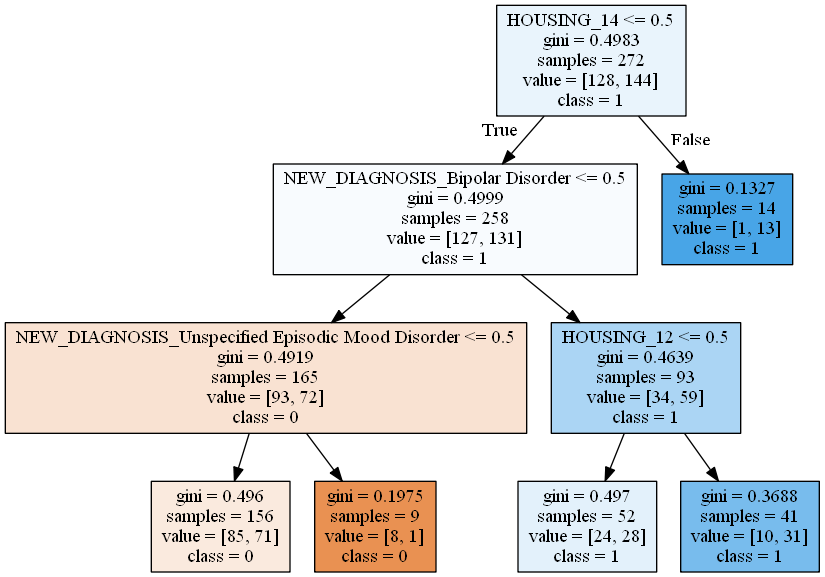

In [18]:
rh_dgtree = rhcars_dd[['HOUSING','NEW_DIAGNOSIS','RISK']]
rh_dgtree = pd.get_dummies(data=rh_dgtree,columns=['NEW_DIAGNOSIS'])
rh_dgtree = pd.get_dummies(data=rh_dgtree,columns=['HOUSING'])

X = rh_dgtree.drop('RISK',axis=1)
Y = rh_dgtree['RISK']
dt = tree.DecisionTreeClassifier(max_depth=3)
dt.fit(X,Y)
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

The first split was made based on Housing 14 which refers to 'Assisted Living' and conveys that these people have a higher risk of rehospitilization. 
We also see (on the left hand side of the tree) that patients diagnosed with Bipolar disorder and who are homeless(Housing = 12) have a higher risk of rehospitilization.

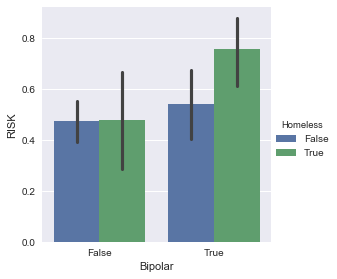

In [19]:
rhcars_dd['Bipolar'] = rhcars_dd['NEW_DIAGNOSIS'] == 'Bipolar Disorder'
rhcars_dd['Homeless'] = rhcars_dd['HOUSING'] == 12
sns.factorplot(data=rhcars_dd,x='Bipolar',y='RISK',hue = 'Homeless',kind='bar')

In [26]:
len(rhcars_dd[(rhcars_dd['NEW_DIAGNOSIS'] == 'Bipolar Disorder') & (rhcars_dd['HOUSING'] == 12) & (rhcars_dd['RISK'] == 1)])

31

In [27]:
len(rhcars_dd[(rhcars_dd['NEW_DIAGNOSIS'] == 'Bipolar Disorder') & (rhcars_dd['HOUSING'] != 12) & (rhcars_dd['RISK'] == 1)])

28